In [8]:
import sys
sys.path.append('..')

import helpers as h
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

INPUT_FOLDER = '../data/dicom/'
patients = h.listdir(INPUT_FOLDER)
patients.sort()

In [5]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [6]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

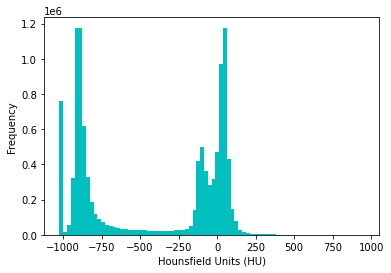

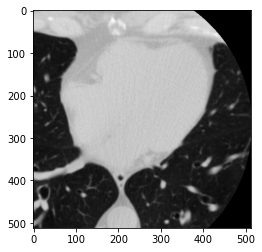

In [10]:
first_patient = load_scan(INPUT_FOLDER + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[20], cmap=plt.cm.gray)
plt.show()

In [34]:
all_scans[4][0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 192
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.12.2.1107.5.1.4.55005.30000013032212170098400001683
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.12.2.1107.5.99.2
(0002, 0013) Implementation Version Name         SH: 'SIEMENS_MMWPE25A'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SEQ']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.01.34.12997,0342336.195
(0008, 0020) Study Date                       

In [18]:
all_scans = [load_scan(INPUT_FOLDER + patient) for patient in patients]

In [37]:
for patient, scan in zip(patients, all_scans):
    slice_locations = np.array([s.SliceLocation for s in scan])
    print(patient, slice_locations.max() - slice_locations.min(), scan[0].SliceThickness)

ACel 123.0 3.0
AEdu 119.99999999999997 3.0
AFre 126.0 3.0
AMar 123.0 3.0
AXav 141.0 3.0
CFer 125.99999999999997 3.0
CLis 105.0 3.0
DLag 120.0 3.0
DSan 105.0 3.0
DSil 159.0 3.0
EGra 141.0 3.0
FGas 141.0 3.0
FPiq 126.0 3.0
ISou 123.0 3.0
JFul 132.0 3.0
JMir 120.00000000000003 3.0
MPai 159.0 3.0
MSil 120.0 3.0
TJes 123.0 3.0
VMar 141.0 3.0


In [72]:
MIN_BOUND = -400
MAX_BOUND = 200.0
    
def normalize(image):
    image[image<MIN_BOUND] = MIN_BOUND
    image[image>MAX_BOUND] = MAX_BOUND
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

In [65]:
PIXEL_MEAN = 0.5

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

In [69]:
p = first_patient_pixels[20]
p = normalize(p)
p = zero_center(p)

In [85]:
OUTPUT_FOLDER = '../data/input_dicom/'
LABELS_FOLDER = '../data/gt_combined/'

import cv2 as cv

for patient in patients:
    slice_count = len(h.listdir(LABELS_FOLDER + patient))
    scan = load_scan(INPUT_FOLDER + patient)
    slices = get_pixels_hu(scan)
    slices = slices[-slice_count:]
    slices = np.flip(slices, 0)
    h.mkdir(OUTPUT_FOLDER + patient)
    for i, s in enumerate(slices):
        s = normalize(s) * 255.0
        cv.imwrite(OUTPUT_FOLDER + patient + '/{:03d}.png'.format(i + 1), s)